In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as p

# Import feature selection package
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2

#set your working_dir
working_dir = "."

# For .read_csv, always use header=0 when you know row 0 is the header row
df = pd.read_csv(working_dir+"/data/ElectionsData-full.csv", header=0)

numeric_fields = df.select_dtypes(exclude=["object"])
categorial_fields = df.select_dtypes(include=["object"])




In [7]:
remove_list = []

def fill_linear_and_remove(f1, f2):
    relation = df[f1].mean() / df[f2].mean()
    df[f1].fillna(df[f2] * relation, inplace=True)
    remove_list.append(f2)

cor = df.corr()
indices = np.where(cor > 0.9)
indices = [(cor.index[x], cor.columns[y]) for x, y in zip(*indices) if x != y and x < y]

for pair in indices:
    fill_linear_and_remove(pair[0], pair[1])

# print df.ix[9973]["Avg_monthly_expense_when_under_age_21"]
# print df.ix[9973]["Avg_Satisfaction_with_previous_vote"]

    
# df[["Avg_monthly_expense_when_under_age_21", "Avg_Satisfaction_with_previous_vote"]]
# df["Avg_monthly_expense_when_under_age_21"].fillna(777, inplace=True)
# df[df["Avg_monthly_expense_when_under_age_21"] == 777]

# df1["rel"] = df1["Avg_monthly_expense_when_under_age_21"] / df1["Avg_Satisfaction_with_previous_vote"]

# df1[df1["rel"] > 1]



# df["Avg_monthly_expense_when_under_age_21" || "Avg_Satisfaction_with_previous_vote"]

# for f in numeric_fields:
#     df[f].fillna(df[f].median(), inplace=True)
    


In [9]:
# Fill categorial fields    
for f in categorial_fields:
    df[f].fillna(df[f].value_counts().idxmax(), inplace=True)
        

# Change all categorial to numeric
ObjFeat=df.keys()[df.dtypes.map(lambda x: x=='object')]

# Transform the original features to categorical
# Creat new 'int' features, resp.
for f in ObjFeat:
    df[f] = df[f].astype("category")
    df[f+"Int"] = df[f].cat.rename_categories(range(df[f].nunique())).astype(int)
    df.loc[df[f].isnull(), f+"Int"] = np.nan #fix NaN conversion

# Outliar detection
threshold = 3
for f in numeric_fields:
    std = df[f].std()
    mean = df[f].mean()
    df = df[df[f].between(mean - threshold *std, mean + threshold *std)]   
      

numeric_fields = df.select_dtypes(exclude=["category"])

for f in numeric_fields:
    if f != "VoteInt":
        df[f] = (df[f] - df[f].min()) / (df[f].max() - df[f].min())
    
df["Age_groupInt"] = df["Age_group"].map( {'Below_30':0, '30-45':1, '45_and_up': 2}).astype(int)
df["Voting_TimeInt"] = df["Voting_Time"].map( {'By_16:00':0, 'After_16:00':1}).astype(int)
df["GenderInt"] = df["Gender"].map( {'Male':-1, 'Female':1}).astype(int)

def transform_bool(name):
    df[name + "_Int"] = df[name].map( {'No':-1, "Maybe": 0, 'Yes':1}).astype(int)

def transform_category(name):
    for cat in df[name].unique():
        df["Is_" + name +"_" + cat] = (df[name] == cat).astype(int)
    
transform_bool("Looking_at_poles_results")
transform_bool("Married")
transform_bool("Financial_agenda_matters")
transform_bool("Will_vote_only_large_party")
transform_category("Most_Important_Issue")
transform_category("Occupation")
transform_category("Main_transportation")

category_features = df.select_dtypes(include=["category"])

df = df.drop(category_features, axis=1)

feat_names = df.drop(['VoteInt'], axis=1).columns.values

# Convert to np array
df_data_X = df.drop(['VoteInt'], axis=1).values
df_data_Y = df.VoteInt.values

In [10]:
# Remove feature with low varriance
varsel = VarianceThreshold(threshold=0.02)
df_data_X = varsel.fit_transform(df_data_X)
featsel_idx = varsel.get_support()

print 'Removing features with low variance - ','\t',feat_names[~featsel_idx]

Removing features with low variance -  	['AVG_lottary_expanses']


In [14]:


# cor.loc[:,:] =  np.tril(cor, k=-1)
# cor = cor.stack()
# cor[cor > 0.9]

df_data_X



array([[ 1.        ,  0.64385519,  0.62322289, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333,  0.74513305,  0.72125531, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.66666667,  0.65580614,  0.63479087, ...,  1.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.11111111,  0.46788206,  0.45288881, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.88888889,  0.60216964,  0.58287315, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.66666667,  0.38962368,  0.37713822, ...,  0.        ,
         1.        ,  0.        ]])

RFE #1
Avg_Satisfaction_with_previous_vote
%Time_invested_in_work
Yearly_IncomeK
Avg_monthly_expense_on_pets_or_plants
Avg_monthly_household_cost
Phone_minutes_10_years
Avg_size_per_room
%_satisfaction_financial_policy
Avg_monthly_income_all_years
Number_of_differnt_parties_voted_for
Political_interest_Total_Score
Number_of_valued_Kneset_members
Num_of_kids_born_last_10_years
Most_Important_IssueInt
Voting_TimeInt
Financial_agenda_mattersInt
Looking_at_poles_results_Int
Financial_agenda_matters_Int
Is_Most_Important_Issue_Environment
Is_Most_Important_Issue_Military
Is_Most_Important_Issue_Social
Is_Most_Important_Issue_Education
Is_Most_Important_Issue_Foreign_Affairs
Optimal number of features : 23


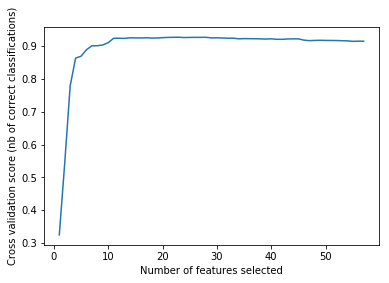

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# The "accuracy" scoring is proportional to the number of correct
# classifications
svc = SVC(kernel="linear", C=1)
rfecv = RFECV(estimator=svc, step=1, cv=3, scoring='accuracy')
rfecv.fit(df_data_X, df_data_Y)

print "RFE #1"
for idx, val in enumerate(rfecv.get_support()):
    if val:
        print feat_names[idx]


minmax = MinMaxScaler()
scores = map(float, rfecv.ranking_)
scores = minmax.fit_transform(-1.0*np.array([scores]).T).T[0]

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 15% most significant features
selector = SelectPercentile(f_classif, percentile=15)
selector.fit(df_data_X, df_data_Y)
f_scores = selector.scores_
f_scores /= f_scores.max()

X_indices = np.arange(df_data_X.shape[-1])

plt.bar(X_indices - .65, f_scores, width=.3,
        label='f_classif', color='g')

print "F CLASSIF"
for idx, val in enumerate(selector.get_support()):
    if val:
        print feat_names[idx]

# Univariate feature selection with mutual information for feature scoring
selector = SelectPercentile(mutual_info_classif, percentile=15)
selector.fit(df_data_X, df_data_Y)
MI_scores = selector.scores_
MI_scores /= MI_scores.max()

print "MI"
for idx, val in enumerate(selector.get_support()):
    if val:
        print feat_names[idx]

plt.bar(X_indices - .35, MI_scores, width=.3,
        label='MI', color='b')


plt.title("Comparing Univariate Feature Selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf = clf.fit(df_data_X, df_data_Y)
tree_weights = clf.feature_importances_  
tree_weights /= tree_weights.max()

plt.bar(X_indices - .05, tree_weights, width=.3, 
        label='Tree weight', color='r')
plt.bar(X_indices - .35, MI_scores, width=.3,
        label='MI', color='b')
plt.bar(X_indices - .65, f_scores, width=.3,
        label='f_classif', color='g')


plt.title("Comparing Univariate and Embedded Feature Selection")
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()

In [65]:
for idx, val in enumerate(rfecv.get_support()):
     if val:
        print df.drop(['VoteInt'], axis=1).columns[idx]

Avg_monthly_expense_when_under_age_21
AVG_lottary_expanses
Avg_Satisfaction_with_previous_vote
Garden_sqr_meter_per_person_in_residancy_area
Yearly_IncomeK
Avg_monthly_expense_on_pets_or_plants
Avg_monthly_household_cost
Phone_minutes_10_years
Avg_size_per_room
Weighted_education_rank
Avg_monthly_income_all_years
Last_school_grades
Political_interest_Total_Score
Number_of_valued_Kneset_members
Overall_happiness_score
Most_Important_IssueInt
Will_vote_only_large_partyInt
Looking_at_poles_results_Int
Married_Int
Will_vote_only_large_party_Int
Is_Most_Important_Issue_Healthcare
Is_Most_Important_Issue_Environment
Is_Most_Important_Issue_Social
Is_Most_Important_Issue_Military
Is_Most_Important_Issue_Financial
Is_Most_Important_Issue_Education
Is_Most_Important_Issue_Other
Is_Most_Important_Issue_Foreign_Affairs


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as p

# Import feature selection package
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif

# For Wrapper Method
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


def load_data_frame():
    working_dir = "."
    # For .read_csv, always use header=0 when you know row 0 is the header row
    df = pd.read_csv(working_dir + "/data/ElectionsData-full.csv", header=0)

    return df

def fill_missing_values(df):
    numeric_fields = df.select_dtypes(exclude=["object"])
    categorial_fields = df.select_dtypes(include=["object"])

    # Fill numeric fields
    for f in numeric_fields:
        df[f].fillna(df[f].median(), inplace=True)

    # Fill categorial fields
    for f in categorial_fields:
        df[f].fillna(df[f].value_counts().idxmax(), inplace=True)

    return df

def transform_categorical_to_int(df):
    # Change all categorical to numeric
    objFeat = df.keys()[df.dtypes.map(lambda x: x == 'object')]
    # Transform the original features to categorical
    # Create new 'int' features, resp.
    for f in objFeat:
        df[f] = df[f].astype("category")
        df[f + "Int"] = df[f].cat.rename_categories(range(df[f].nunique())).astype(int)
        df.loc[df[f].isnull(), f + "Int"] = np.nan    # fix NaN conversion

    return df

def filter_outliar_detection(df):
    numeric_fields = df.select_dtypes(exclude=["category"])

    threshold = 3
    for f in numeric_fields:
        std = df[f].std()
        mean = df[f].mean()
        df = df[df[f].between(mean - threshold * std, mean + threshold * std)]

    return df


def scale_numeric(df):
    numeric_fields = df.select_dtypes(exclude=["category"])

    for f in numeric_fields:
        if f != "VoteInt":
            df[f] = (df[f] - df[f].min()) / (df[f].max() - df[f].min())

    return df

def transform_categorical(df):
    df["Age_groupInt"] = df["Age_group"].map({'Below_30': 0, '30-45': 1, '45_and_up': 2}).astype(int)
    df["Voting_TimeInt"] = df["Voting_Time"].map({'By_16:00': 0, 'After_16:00': 1}).astype(int)
    df["GenderInt"] = df["Gender"].map({'Male': -1, 'Female': 1}).astype(int)

    def transform_bool(name):
        df[name + "_Int"] = df[name].map({'No': -1, "Maybe": 0, 'Yes': 1}).astype(int)

    def transform_category(name):
        for cat in df[name].unique():
            df["Is_" + name + "_" + cat] = (df[name] == cat).astype(int)

    transform_bool("Looking_at_poles_results")
    transform_bool("Married")
    transform_bool("Financial_agenda_matters")
    transform_bool("Will_vote_only_large_party")
    transform_category("Most_Important_Issue")
    transform_category("Occupation")
    transform_category("Main_transportation")

    return df


def to_np_array(df):
    category_features = df.select_dtypes(include=["category"])

    df_no_cat = df.drop(category_features, axis=1)

    feat_names = df_no_cat.drop(['VoteInt'], axis=1).columns.values

    # Convert to np array
    df_data_x = df_no_cat.drop(['VoteInt'], axis=1).values
    df_data_y = df_no_cat.VoteInt.values

    return df_data_x, df_data_y, feat_names


def filter_by_variance(data_x, feat_names):
    varsel = VarianceThreshold(threshold=0.01)
    data_x = varsel.fit_transform(data_x)
    featsel_idx = varsel.get_support()

    print 'Removing features with low variance - ', '\t', feat_names[~featsel_idx]

    return data_x

def main():
    # set your working_dir
    df = load_data_frame()
    df = fill_missing_values(df)
    df = transform_categorical_to_int(df)
    df = filter_outliar_detection(df)
    df = scale_numeric(df)
    df = transform_categorical(df)

    df_data_x, df_data_y, feature_names = to_np_array(df)

    filter_by_variance(df_data_x, feature_names)
#     df_data_x = filter_by_variance(df_data_x, feature_names)
#     wrapper_method(df_data_x, df_data_y, feature_names)
#     univariate_feature_selection(df_data_x, df_data_y, feature_names)
    
    return df


def univariate_feature_selection(df_data_x, df_data_y, feature_names):
    selector = SelectPercentile(f_classif, percentile=15)
    selector.fit(df_data_x, df_data_y)
    f_scores = selector.scores_
    f_scores /= f_scores.max()

    print "F CLASSIF:"
    for idx, val in enumerate(selector.get_support()):
        if val:
            print feature_names[idx]

    selector = SelectPercentile(mutual_info_classif, percentile=15)
    selector.fit(df_data_x, df_data_y)

    print "MI:"
    for idx, val in enumerate(selector.get_support()):
        if val:
            print feature_names[idx]


def wrapper_method(df_data_x, df_data_y, feature_names):
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    svc = SVC(kernel="linear", C=1)
    rfecv = RFECV(estimator=svc, step=1, cv=3, scoring='accuracy')
    rfecv.fit(df_data_x, df_data_y)

    print("Optimal features by linear SVC : %d" % rfecv.n_features_)
    for idx, val in enumerate(rfecv.get_support()):
        if val:
            print feature_names[idx]



main()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').